We start by loading in the Twitter dataset as described in the synopsis. 

In [1]:
import gc
import string
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('words')
import gensim.downloader as api
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Load in the raw data

In [2]:
raw = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', on_bad_lines='skip', names='target,user_id,date,flag,user,text'.split(','))

Initial data exploration

In [3]:
raw.head()

,target,user_id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
raw['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Sample 20,000 rows from the original dataset

In [5]:
# stratified sampling
tweets = raw.groupby('target').apply(lambda x: x.sample(10000, random_state=42))

In [6]:
tweets = tweets.reset_index(drop=True)

In [7]:
tweets['target'].value_counts()

0    10000
4    10000
Name: target, dtype: int64

In [8]:
tweets.head()

,target,user_id,date,flag,user,text
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I..."
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...


Now, we write a function that cleans the data. I will detail what each line of code does to make it clear.

In [9]:
# apply this to each tweet
def clean_data(tweet):
    # removal of punctuations
    tweet = re.sub("[^-9A-Za-z ]", "" , tweet)
    # convert to lowercase
    tweet = "".join([i.lower() for i in tweet if i not in string.punctuation])
    # tokenize the words temporarily
    word_tokens = nltk.tokenize.word_tokenize(tweet)
    # removal of non-alphabetical words
    word_tokens = [w for w in word_tokens if w.isalpha()]
    # removal of non-english words like usernames
    words = set(nltk.corpus.words.words())
    word_tokens = [w for w in word_tokens if w in words]
    # removal of stop-words
    stop_words = nltk.corpus.stopwords.words('english')
    word_tokens = [w for w in word_tokens if not w in stop_words]
    # # stemming
    # stemmer = nltk.stem.PorterStemmer()
    # word_tokens = [stemmer.stem(w) for w in word_tokens]
    # join back as string
    tweet = " ".join(word_tokens)
    return tweet

In [12]:
# compare the tweet before and after processing
print('Original:', tweets['text'][0])
print('Processed:', clean_data(tweets['text'][0]))

Original: @xnausikaax oh no! where did u order from? that's horrible 
Processed: oh u order that horribl


In [ ]:
tweets['cleaned_text'] = tweets['text'].apply(clean_data)
tweets = tweets.drop(columns=['text'])
tweets.head()

In [14]:
import gc
gc.collect()

2159

Save as a csv file

In [ ]:
tweets.to_csv('tweets.csv')

Now, we have the sampled dataset with pre-processed tweet text.

In [15]:
tweets = pd.read_csv('tweets.csv', index_col=0)

In [16]:
tweets = tweets.drop(columns=['user_id', 'date', 'flag', 'user'])

In [17]:
tweets.head()

,target,cleaned_text
0,0,oh u order that horribl
1,0,great hard train weekend coupl day rest lot co...
2,0,right work go free
3,0,crave food
4,0,jean concert tomorrow got ta work though


Remove any rows that have missing null values for cleaned text. 
This ensures that the pre-trained model has no issues processing the text.

In [18]:
tweets = tweets.dropna(axis=0)

In [21]:
tweets['target'] = tweets['target'].apply(lambda x: 1 if x==4 else 0)

Now, we obtain the phrasal embeddings for each cleaned tweet text in the tweets dataframe.
We use the GloVe Twitter 25 model, which contains pre-trained GloVe vectors based on 2 billion tweets, 27 billion tokens, and 1.2 million vocabulary.

Load in the pre-trained model

In [66]:
model = api.load('glove-twitter-25')

In [24]:
# takes in a tweet and outputs a list of word embeddings for each word
def get_embeddings(text):
    return np.array([model[w] for w in text.split() if model.__contains__(w)])

tweets['tokenized_text'] = tweets['cleaned_text'].apply(get_embeddings)
tweets.head()

,target,cleaned_text,tokenized_text
0,0,oh u order that horribl,"[[0.34172, -0.17305, 0.23311, 0.057375, -0.761..."
1,0,great hard train weekend coupl day rest lot co...,"[[-0.84229, 0.36512, -0.38841, -0.46118, 0.243..."
2,0,right work go free,"[[-0.43876, 0.095692, 0.0030075, -0.13195, -0...."
3,0,crave food,"[[-0.85832, 0.48558, -0.61313, 0.72877, -0.656..."
4,0,jean concert tomorrow got ta work though,"[[-0.70756, -1.2247, 0.087766, 0.27264, -0.412..."


In [52]:
sum([tweets['tokenized_text'][0][0], tweets['tokenized_text'][0][0]]) - tweets['tokenized_text'][0][0]*2



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Save as a csv file

In [25]:
tweets.to_csv('tweets.csv')

## Defining the Cluster Points and Centroids

In this section, we will define the cluster points and centroids in an OOP format. 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gc
import string
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('words')
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import spatial

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, roc_auc_score


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# model = api.load('glove-twitter-25')
tweets = pd.read_csv('tweets.csv', index_col=0)
tweets

,target,cleaned_text,tokenized_text
0,0,oh u order thats horrible,[[ 3.4172e-01 -1.7305e-01 2.3311e-01 5.7375e...
1,0,great hard training weekend couple days rest l...,[[-8.4229e-01 3.6512e-01 -3.8841e-01 -4.6118e...
2,0,right work go free,[[-4.3876e-01 9.5692e-02 3.0075e-03 -1.3195e...
3,0,craving food,[[-1.2275 0.61425 0.23204 0.4787 -0.5...
4,0,jean concert tomorrow got ta work though,[[-7.0756e-01 -1.2247e+00 8.7766e-02 2.7264e...
...,...,...,...
19995,1,arms morning baby face boy guitar hero,[[-1.4197 -0.59392 0.034198 0.7004 0.1...
19996,1,sweet mother extend royal welcome,[[-1.0864 -0.61674 0.33613 0.43232 -0.2...
19997,1,wouldnt mind watching derby mint julep,[[ 5.7749e-02 1.3264e+00 -1.6871e-02 -5.5858e...
19998,1,shiny nice like shiny hate vista mean passion,[[-9.4931e-01 -5.5718e-01 1.3540e-01 -1.2416e...


### Splitting Data into Training, Validation and Testing data

In this section, we will be splitting the tweets into training, validation and testing sets. The proportion will be as follows:
1. Training: 0.70
2. Validating: 0.15
3. Testing: 0.15

In [75]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE = 42
MAX_TWEET_LENGTH = 280
VISUALISATION_LOC = 'visualisation/'

In [49]:
tweets_sampled = tweets.sample(100, random_state=RANDOM_STATE)
tweets_sampled

,target,cleaned_text,tokenized_text
9213,0,yolk best bit,[[-1.7264e-01 -3.6231e-01 3.6885e-01 8.2955e...
18833,1,fist one u bet second one yep fun,[[-9.4536e-01 4.2714e-01 2.9669e-01 9.2002e...
2357,0,lot hungry u,[[ 1.6807e-01 4.8304e-01 3.1292e-02 3.9010e...
3696,0,neck,[[-1.2556e+00 -5.3265e-01 1.5854e-01 8.2836e...
2889,0,pool goddess us lost next match wont going bet...,[[-1.5123e+00 2.5732e-01 7.6255e-01 -4.6525e...
...,...,...,...
15642,1,hope except subject still despite promising do...,[[-7.6599e-01 8.0836e-01 1.5636e-02 -2.2972e...
16693,1,foggy really great grateful blessed daily big hug,[[-1.7562e+00 -1.1962e+00 3.1832e-01 -5.1534e...
16307,1,much closer ever,[[-0.23837 0.19072 -0.24646 0.10111 -0.3...
4503,0,yeah old episode like season one marcel monkey...,[[ 0.29137 0.36113 0.44268 -0.49594 ...


In [50]:
X = tweets_sampled['cleaned_text']
y = tweets_sampled.target

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, shuffle=True)

print(
    f'X_train: {X_train.shape[0]} \n'
    f'X_test: {X_test.shape[0]} \n'
    f'y_train: {y_train.shape[0]} \n'
    f'y_test: {y_test.shape[0]} \n'
)

X_train: 70 
X_test: 30 
y_train: 70 
y_test: 30 



##### Defining the Cluster Points and Centroids

In this section, we will define the cluster points and centroids in an OOP format. 

In [77]:
class Point:
    '''
    A class used to represent each word in a document
    ...

    Attributes
    ----------
    word : str
        The word represented by the point

    vector : array
        The vector representation of the word
    
    closest_centroid : Centroid
        The closest centroid to the point

    cosine_similarity_with_centroid : Centroid
        The cosine similarity with the point's closest centroid

    polarity : Float
        The polarity of the point as determined by the polarity of its closest centroid


    Methods
    ----------
    reset_point()
        resets the Point's closest centroid, similarity score and polarity to None

    set_centroid(centroid)
        Stores the centroid the point is assigned to

    set_cosine_similarity_with_centroid(similarity)
        Sets the cosine similarity between the point and its closest centroid

    set_polarity(polarity)
        Sets the polarity of the point as determined by the polarity of its closest centroid

    get_cosine_similarity_with_centroid(mean_distance=False)
        Returns the cosine similarity

    '''
    def __init__(self, word, model):
        self.word = word 
        self.vector = model[word] if model.__contains__(word) else None
        self.closest_centroid = None
        self.cosine_similarity_with_centroid = None
        self.polarity = None

    def reset_point(self):
        self.closest_centroid = None
        self.cosine_similarity_with_centroid = None
        self.polarity = None
        return True

    def set_centroid(self, centroid):
        self.closest_centroid = centroid
        return True

    def set_cosine_similarity_with_centroid(self, similarity):
        self.cosine_similarity_with_centroid = similarity
        return True

    def set_polarity(self, polarity):
        self.polarity = polarity
        return True

    def get_cosine_similarity_with_centroid(self, mean_distance=True):
        if self.closest_centroid is not None:
            if not mean_distance:
                return self.cosine_similarity_with_centroid
            else:
                return np.mean([point.cosine_similarity_with_centroid for point in self.closest_centroid.cluster_points])
        else:
            raise Exception('Unable to calculate cosine similarity with NoneType: Centroid is undefined')

In [76]:
class Centroid(Point):
    '''
    A class used to represent each word in the lexical dictionary as a centroid. 
    ...

    Attributes
    ----------
    word : str
        The word represented by the point

    vector : array
        The vector representation of the word
    
    closest_centroid : Centroid
        The closest centroid to the point

    cosine_similarity_with_centroid : Centroid
        The cosine similarity with the point's closest centroid

    polarity : Float
        The polarity of the point as determined by the polarity of its closest centroid

    cluster_points : List(Points)
        A list containing the Points assigned to the centroid as a cluster


    Methods
    ----------
    resest_cluster()
        Resets all the cluster's points and resets the cluster to an empty list.

    add_point_to_cluster(point, similarity)
        Adds a Point to the centroid's cluster. Updates the Point's polarity, centroid and cosine similarity with that of and with the Centroid

    update_vector_location()
        For use in the dynamic clustering algorithm. Updates the vector location to the mean of all its points.

    '''
    def __init__(self, word, polarity, model):
        super().__init__(word, model)
        self.polarity = polarity
        self.cluster_points = []

    def reset_cluster(self):
        for point in self.cluster_points:
            point.reset_point()
        self.cluster_points = []
        return True

    def add_point_to_cluster(self, point, similarity):
        self.cluster_points.append(point)
        point.set_polarity(self.polarity)
        point.set_centroid(self)
        point.set_cosine_similarity_with_centroid(similarity)
        return True

    def remove_point_from_cluster(self, point):
        self.cluster_points.remove(point)
        point.reset_point()
        return True

    def update_vector_location(self):
        cluster_mean = sum([point.vector for point in self.cluster_points])/len(self.cluster_points)
        self.vector = cluster_mean
        return True

In [99]:
import random
class VectorSpaceVisualiser:
    def __init__(self, Vector_Space):
        self.vector_space = Vector_Space

    def plot(self, n_point, n_centroid, file_name, save_plot=False):
        tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
        plt.figure(figsize=(20,20))

        # retrieving words
        random.seed(RANDOM_STATE) # can set to other number and see how
        sampled_points = random.sample(self.vector_space.points, n_point)
        words = []
        vectors = []
        for point in sampled_points:
            if point.word not in words: # make sure there's no repeated words
                words.append(point.word)
                vectors.append(point.vector)
        words = np.array(words)
        vectors = np.array(vectors)
        n_unique_words = words.shape[0]
        print(f"number of unique words plotted is {n_unique_words}")


        # retrieving their closest centroids
        centroids = [point.closest_centroid for point in sampled_points]
        centroids.sort(reverse = True, key = lambda x: len(x.cluster_points))

        # make sure centroids with the most number of cluster points are plotted first
        lexicons = []
        lexicon_vectors = []
        for centroid in centroids:
            if centroid.word not in lexicons: # make sure there's no repeated words
                lexicons.append(centroid.word)
                lexicon_vectors.append(centroid.vector)
        lexicons = np.array(lexicons)[:n_centroid]
        lexicon_vectors = np.array(lexicon_vectors)[:n_centroid]
        print(f"the list of {lexicons.shape[0]} lexicons centroids plotted is as follows, {lexicons}")

        conc_vectors = np.concatenate((vectors, lexicon_vectors))
        conc_tsne = tsne.fit_transform(conc_vectors) # transforming to 2D
        print(f"shape of concatenated 2D TSNE vector is {conc_tsne.shape}")

        X_tsne = conc_tsne[:n_unique_words, :]
        centroid_tsne = conc_tsne[n_unique_words+1:, :]

        # plotting points
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = 'b')
        for label, x, y in zip(words, X_tsne[:, 0], X_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset pixels", c = 'b', fontsize = 25)

        # plotting centroids
        plt.scatter(centroid_tsne[:, 0], centroid_tsne[:, 1], color = 'y', marker = 'x')
        for label, x, y in zip(lexicons, centroid_tsne[:, 0], centroid_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset pixels", c = 'y', fontsize = 25)

        plt.title(file_name, fontsize=40)
        
        if save_plot:
            plt.savefig(f"{VISUALISATION_LOC}{file_name}.png")
            print("SUCCESS: Plot saved successfully")

        plt.show()

In [103]:
class VectorSpace:
    '''
    A class used to represent the Vector Space which will contain the points and centroids. 
    Separate VectorSpaces should be used for the Static and Dynamic Clustering approaches respectively.
    ...

    Attributes
    ----------
    points : List(Points)
        The list of Points within the vector space.

    centroids : List(Centroids)
        The list of Centroids within the vector space.

    points_look_up_table : Dict(Str:Point)
        A look-up table to store the reference Points of each word. Allows for efficient translation of text to Point attributes
    
    centroids_look_up_table : Dict(Str:Point)
        A look-up table to store the reference Centroid of each word. Allows for efficient translation of text to Centroid attributes

    word2vec_model : Model
        The word embedding model used to embed words into the VectorSpace. ie. GloVe-Twitter-25

    lexicon : Dict(Str:Float)
        The sentiment lexical dictionary used for the VectorSpace. 

    Methods
    ----------
    inject_point(point)
        Injects a point into the vector space and updates the Points look-up table.

    inject_centroid(centroid)
        Injects a centroid into the vector space and updates the Centroids look-up table

    tweet_to_vector_space(tweet, model)
        Converts a tweet, aka document, of words into their respective points and injects the points into the vector space. 
        The model is the embedding model used to tokenise the text.
        If the model does not contain the word, the Point is not created.

    load_lexicon(lexical analyser)
        Loads the lexical dictionary from the lexical analyser and stores within the VectorSpace object.

    lexicon_to_vector_space(word, polarity, model)
        Converts a word from the sentiment lexical dictionary into a Centroid and injects it into the vector space.
        The model is the embedding model used to tokenise the text.
        If the model does not contain the word, the Centroid is not created.

    init_centroids()
        Initialises centroids into the VectorSpace based in the Lexical Dictionary

    calculate_cosine_similarity(point1, point2)
        Calculates the cosine similarity between 2 Points. Utilises Numpy matrix operations for increased efficiency.

    get_most_similar_centroid(point)
        Locates the closest Centroid to the Point from all the Centroids within the VectorSpace based on Cosine Similarity. 
        Returns the closest centroid and the Cosine Similarity between the point and the Centroid.

    assign_static_clusters()
        Executes the static clustering algorithm based on the paper "Improvement of Sentiment Analysis based on clustring of Word2Vec".

    assign_dynamic_clusters()
        Executes the proposed dynamic clustering algorithm.

    get_similarity_score_of_unseen_word(word)
        For an unseen word in the testing data, return its closest centroid and cosine similarity score.

    translate_text_to_similarity(document, static=False, dynamic=False)
        Translates a document of words into their respective similarity scores. 
        If an unseen word is encountered from testing data, get_similarity_score_of_unseen_word will be executed.
        If a Centroid has negative polarity, the similarity will be transformed by a multiplicative factor of -1
        If static, the mean similarity scores of all the points within a certain centroid will be returned for all these Points.
        If dynamic, the raw similary will be returned

    fit(Series, static=False, dynamic=False)
        Main client facing function. This operation will train the VectorSpace with the series of tweets.

    transform(Series, static=False, dynamic=False)
        Transforms words within a series of String to their respective similarity scores. 

    plot_points(n)
        Plots the first n unique Points and Centroids on a 2-dimensional plane.

    '''
    def __init__(self, word2vec_model, lexicon_dictionary):
        self.points = []
        self.centroids = []
        self.points_look_up_table = {}
        self.centroids_look_up_table = {}
        self.word2vec_model = word2vec_model
        self.load_lexicon(lexicon_dictionary)
        self.init_centroids()
        print(f"SUCCESS: VectorSpace initialised with {len(self.centroids)} centroids")

    def inject_point(self, point):
        self.points.append(point)
        self.points_look_up_table[point.word] = point
        return True
    
    def inject_centroid(self, centroid):
        self.centroids.append(centroid)
        self.centroids_look_up_table[centroid.word] = centroid
        return True

    def tweet_to_vector_space(self, tweet, word2vec_model, verbose=False):
        for word in tweet.split():
            if word2vec_model.__contains__(word):
                self.inject_point(Point(word, self.word2vec_model))
            else:
                if verbose:
                    print(f"INFO: Model does not contain {word}")
        return True

    def load_lexicon(self, lexicon_dictionary):
        self.lexicons = lexicon_dictionary.lexicon
        return True

    def lexicon_to_vector_space(self, word, polarity, model):
        if model.__contains__(word):
            self.inject_centroid(Centroid(word, polarity, model))
        return True

    def init_centroids(self):
        for word, polarity in self.lexicons.items():
            self.lexicon_to_vector_space(word, polarity, self.word2vec_model)
        return True

    def calculate_cosine_similarity(self, point1, point2):
        return np.dot(point1.vector, point2.vector)/(np.linalg.norm(point1.vector)* np.linalg.norm(point2.vector))

    def get_most_similar_centroid(self, point):
        most_similar_centroid = None
        max_similarity = 0

        for centroid in self.centroids:
            similarity = self.calculate_cosine_similarity(point, centroid)
            if similarity > max_similarity:
                most_similar_centroid = centroid
                max_similarity = similarity

        return most_similar_centroid, max_similarity

    def assign_static_clusters(self, save_plot=False):
        # Implement static cluster algorithm
        for point in tqdm(self.points, desc="Assigning Points to Clusters..."):
            most_similar_centroid, max_similarity = self.get_most_similar_centroid(point)
            most_similar_centroid.add_point_to_cluster(point, max_similarity)
        if save_plot:
            visualiser = VectorSpaceVisualiser(self)
            visualiser.plot(n_point=100, n_centroid= 50,  file_name=f"static", save_plot=True)

        return True

    def assign_dynamic_clusters(self, max_iterations = 20, save_plot=False):
        # Implement dynamic cluster algorithm
        # not a single point changes cluster in 1 iteration, or can try setting a max iteration
        centroid_change_flag = True
        counter = 1
        self.assign_static_clusters()
        if save_plot:
            visualiser = VectorSpaceVisualiser(self)
            visualiser.plot(n_point=100, n_centroid= 50,  file_name=f"dynamic_iter_{0}", save_plot=True)
        while centroid_change_flag and counter <= max_iterations:
            print(f"INFO: Iteration {counter}")
            centroid_change_flag = False
            
            for centroid in tqdm(self.centroids, desc="Updating Centroid Locations"):
                if len(centroid.cluster_points) > 0:
                    centroid.update_vector_location()
            for point in tqdm(self.points, desc="Reassigning Points"):
                most_similar_centroid, max_similarity = self.get_most_similar_centroid(point)
                if most_similar_centroid is not point.closest_centroid:
                    # print("reassigned")
                    centroid_change_flag = True
                    point.closest_centroid.remove_point_from_cluster(point)
                    most_similar_centroid.add_point_to_cluster(point, max_similarity)
            
            if save_plot:
                visualiser = VectorSpaceVisualiser(self)
                visualiser.plot(n_point=100, n_centroid= 50,  file_name=f"dynamic_iter_{counter}", save_plot=True)
            counter += 1
        return True

    def get_similarity_score_of_unseen_word(self, word):
        most_similar_centroid, max_similarity = self.get_most_similar_centroid(Point(word, self.word2vec_model))
        # Consider mean values for centroids with points inside
        return most_similar_centroid, max_similarity

    def translate_text_to_similarity(self, document, static=False, dynamic=False):
        output = []
        for word in document.split():
            if self.word2vec_model.__contains__(word):
                if word not in self.points_look_up_table: # unseen test vocabulary
                    most_similar_centroid, similarity_score = self.get_similarity_score_of_unseen_word(word)
                    if most_similar_centroid.polarity < 0:
                        similarity_score = -1 * similarity_score
                else:
                    similarity_score = self.points_look_up_table[word].get_cosine_similarity_with_centroid(mean_distance=True)
                    if self.points_look_up_table[word].polarity < 0:
                        similarity_score =  -1 * similarity_score
                output.append(similarity_score)
        output += [0] * (MAX_TWEET_LENGTH - len(output))         

        return np.array(output)

    def fit(self, X_train, static=False, dynamic=False, max_iterations = 20, save_plot=False):
        if not static and not dynamic:
            raise Exception("Please specify static or dynamic fitting")
        
        X_train.apply(lambda x: self.tweet_to_vector_space(x, word2vec_model=self.word2vec_model))
       
        if static:
            self.assign_static_clusters(save_plot=save_plot)
        elif dynamic:
            self.assign_dynamic_clusters(max_iterations = 20, save_plot=save_plot)

        return True

    def transform(self, X, static=False, dynamic=False):
        if not static and not dynamic:
            raise Exception("Please specify static or dynamic transformation")
        X_transformed = X.apply(lambda x: self.translate_text_to_similarity(x, static=static, dynamic=dynamic))
        return np.array(X_transformed.tolist())


    def plot_points(self, n):
        words = []
        vectors = []
        for point in self.points:
            if point.word not in words:
                words.append(point.word)
                vectors.append(point.vector)

        words = np.asarray(words)[:n]
        vectors = np.array(vectors)[:n]
        centroids = np.array([c.vector for c in self.centroids])
        
        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(vectors)
        plt.figure(figsize=(20,20))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        for label, x, y in zip(words, X_tsne[:, 0], X_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
        plt.show()
                

### Training the Static Vector Space

#### Injecting Training Set into Vector Space

In this section, we will initialise a VectorSpace, and populate it with words from the training Tweets. At the same time, we will maintain a hashtable to keep track of the corresponding point for each word that we can translate the points back to words in the form of the respective maximum similarity value in O(1) time.

In [85]:
X_train.head()

13709                              lighter indelible grand
6365      parent thing school help either r usually phoebe
13464                                       well sure like
8778     yes smart way look seriously supposed pack wor...
12577             totally theres thing fun exciting lesson
Name: cleaned_text, dtype: object

In [56]:
analyzer = SentimentIntensityAnalyzer()
word2vec_model = gensim_api.load('glove-twitter-25')

### Initialising and Training Static and Dynamic VectorSpaces

SUCCESS: VectorSpace initialised with 4880 centroids


Assigning Points to Clusters...: 100%|██████████| 414/414 [00:14<00:00, 27.91it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'better' 'good' 'l' 'leave' 'lost' 'ill' 'hope' 'fun' 'glad'
 'dream' 'yeah' 'number' 'holiday' 'spam' 'sure' 'clean' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'heaven' 'boring' 'limited' 'missed'
 'dick' 'comedy' 'drop' 'seriously' 'rebel' 'wag' 'warm' 'easy' 'cheer'
 'best' 'sad' 'swear' 'exciting' 'trouble' 'smh' 'devil' 'piss' 'smart'
 'straight' 'fume' 'cry' 'enjoying']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


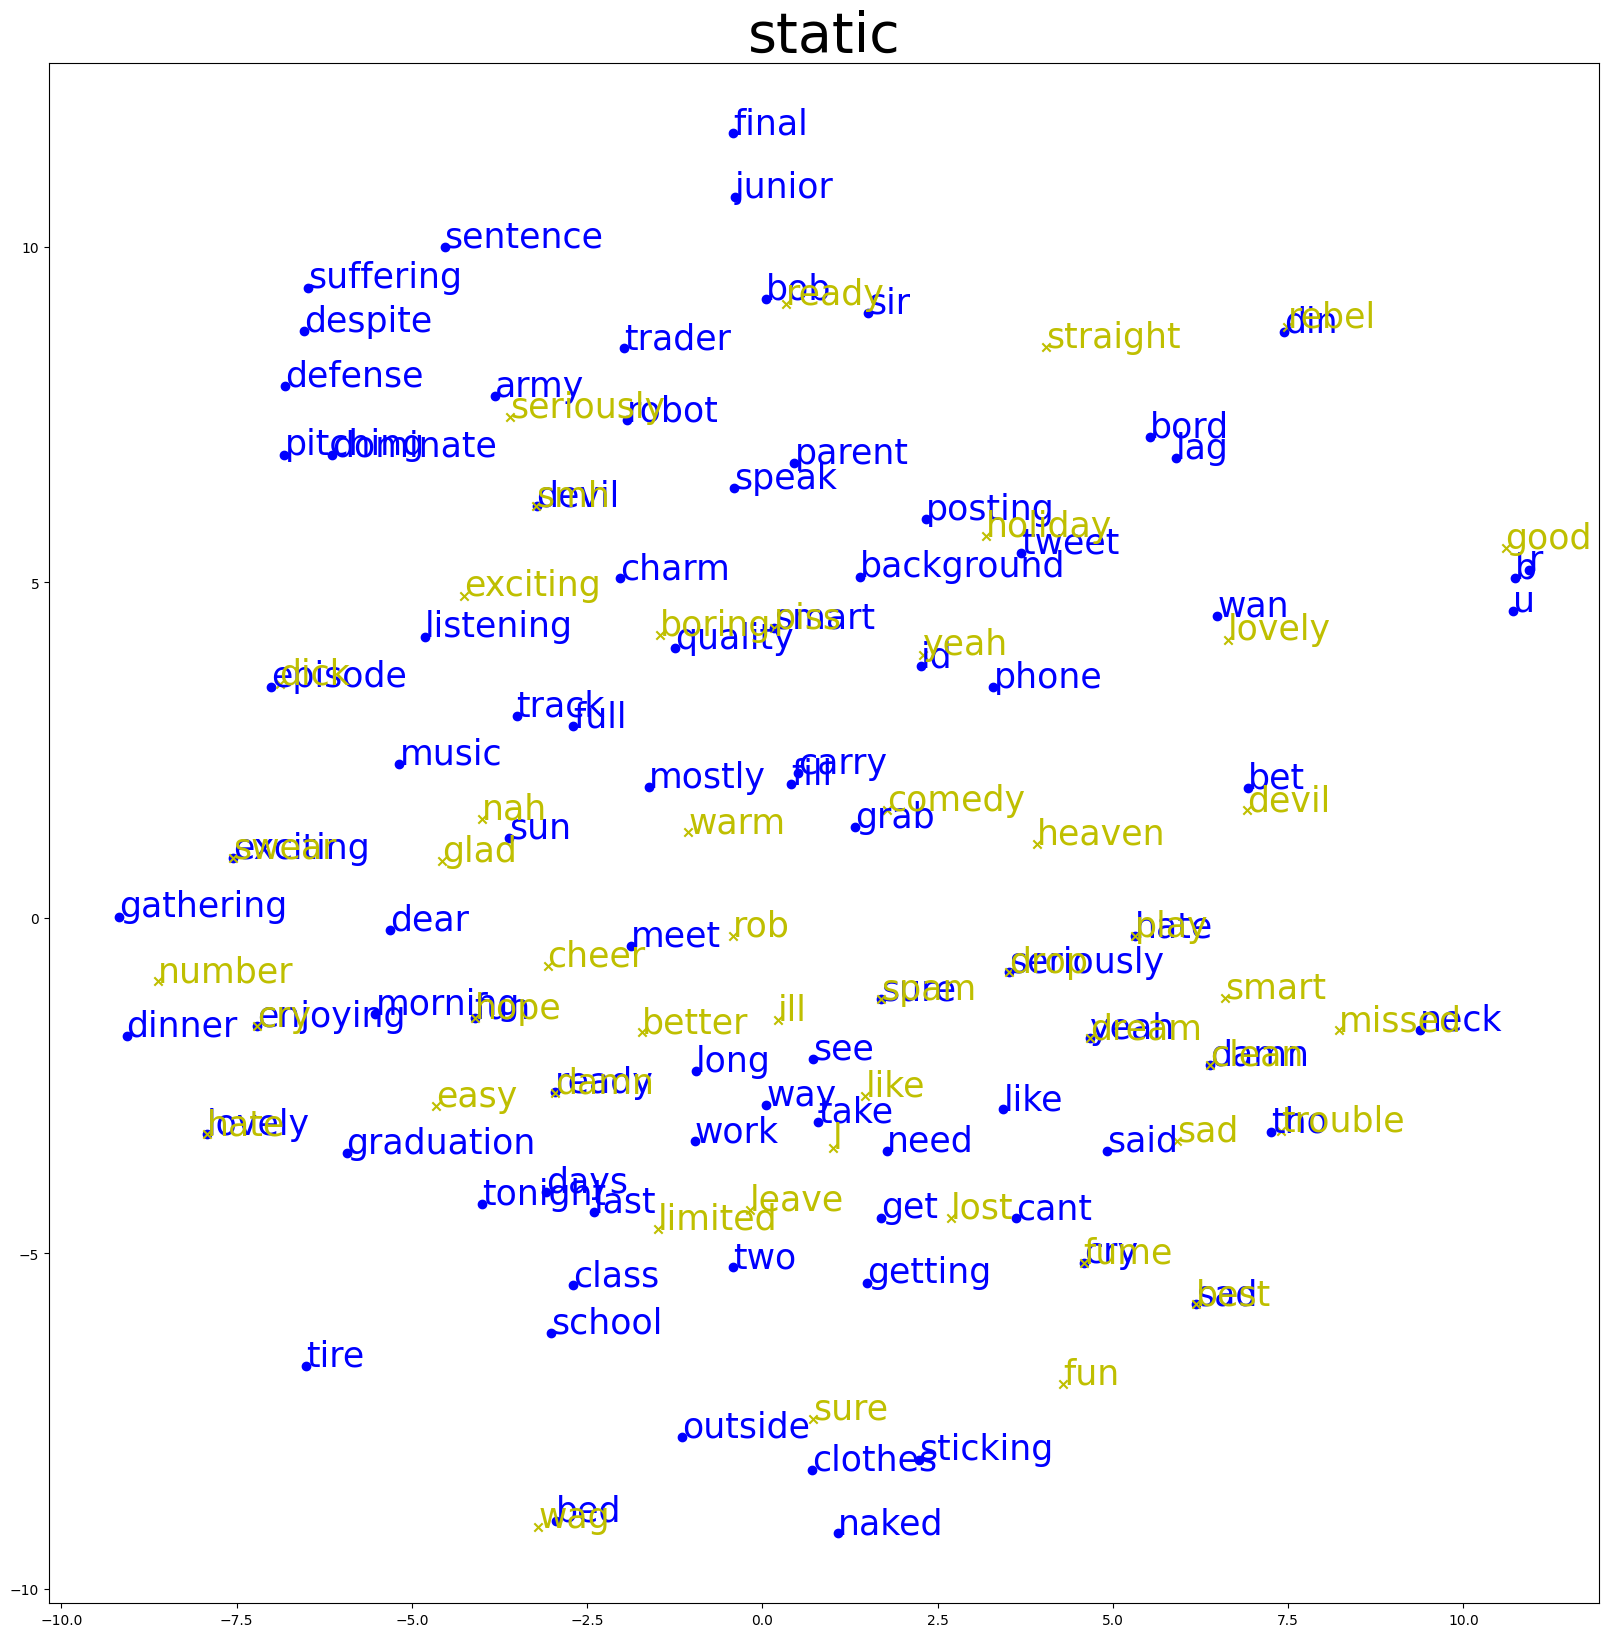

True

In [101]:
vector_space_static = VectorSpace(word2vec_model, analyzer)
vector_space_static.fit(X_train, static=True, save_plot=True)

SUCCESS: VectorSpace initialised with 4880 centroids


Assigning Points to Clusters...: 100%|██████████| 414/414 [00:14<00:00, 28.85it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'better' 'good' 'l' 'leave' 'lost' 'ill' 'hope' 'fun' 'glad'
 'dream' 'yeah' 'number' 'holiday' 'spam' 'sure' 'clean' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'heaven' 'boring' 'limited' 'missed'
 'dick' 'comedy' 'drop' 'seriously' 'rebel' 'wag' 'warm' 'easy' 'cheer'
 'best' 'sad' 'swear' 'exciting' 'trouble' 'smh' 'devil' 'piss' 'smart'
 'straight' 'fume' 'cry' 'enjoying']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


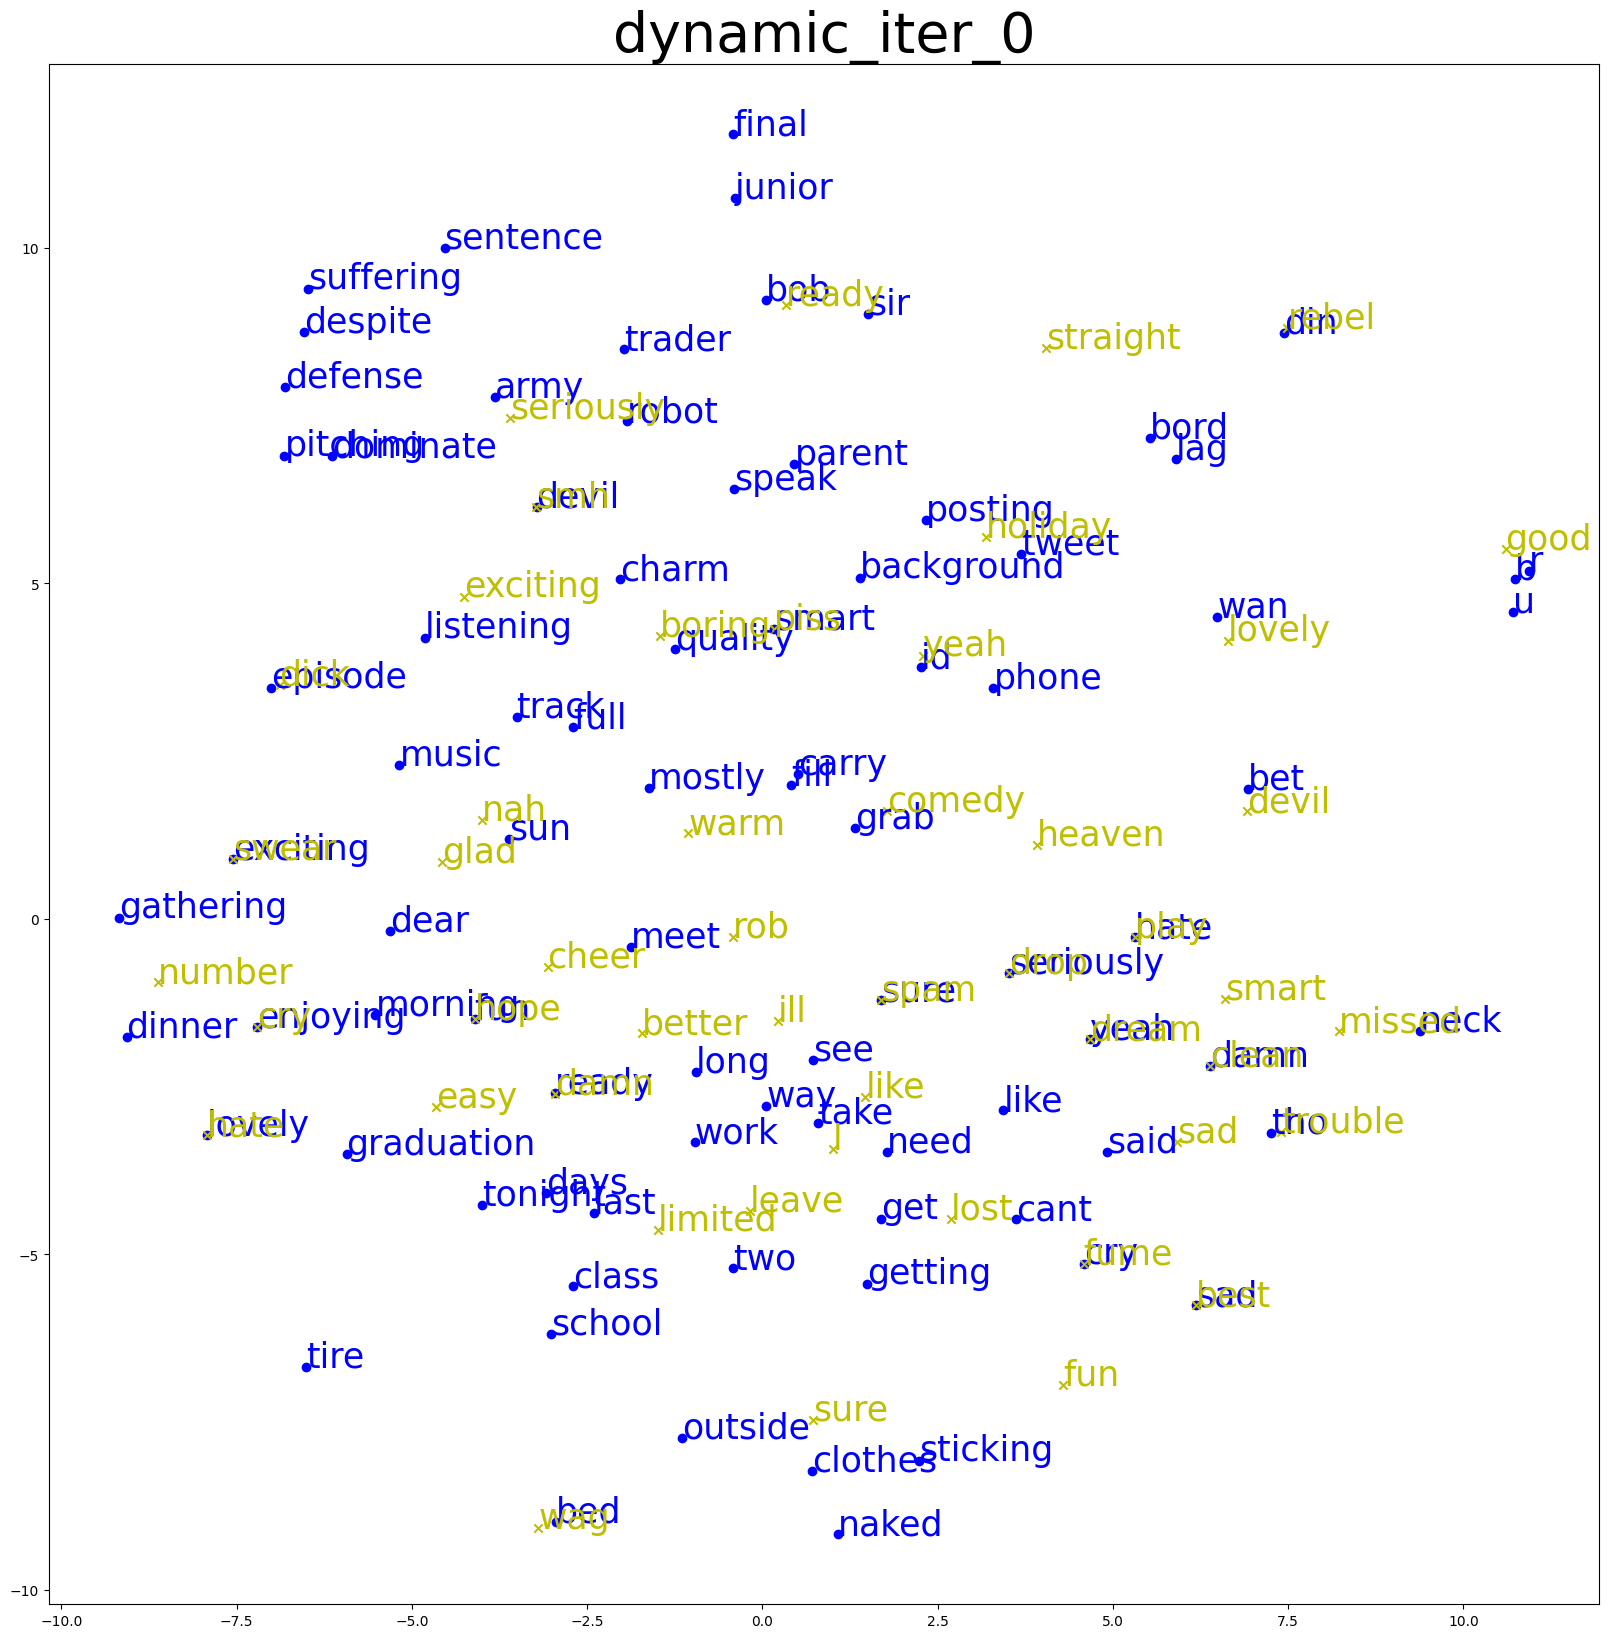

INFO: Iteration 1


Reassigning Points: 100%|██████████| 414/414 [00:14<00:00, 28.19it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'better' 'good' 'l' 'leave' 'lost' 'ill' 'hope' 'fun' 'yeah'
 'glad' 'dream' 'number' 'holiday' 'spam' 'sure' 'damn' 'ready' 'rob'
 'play' 'hate' 'lovely' 'nah' 'easy' 'stuck' 'heaven' 'trouble' 'boring'
 'limited' 'steal' 'missed' 'dick' 'clean' 'comedy' 'drop' 'seriously'
 'rebel' 'wag' 'warm' 'cheer' 'best' 'sad' 'swear' 'exciting' 'smh'
 'devil' 'piss' 'smart' 'straight' 'fume']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


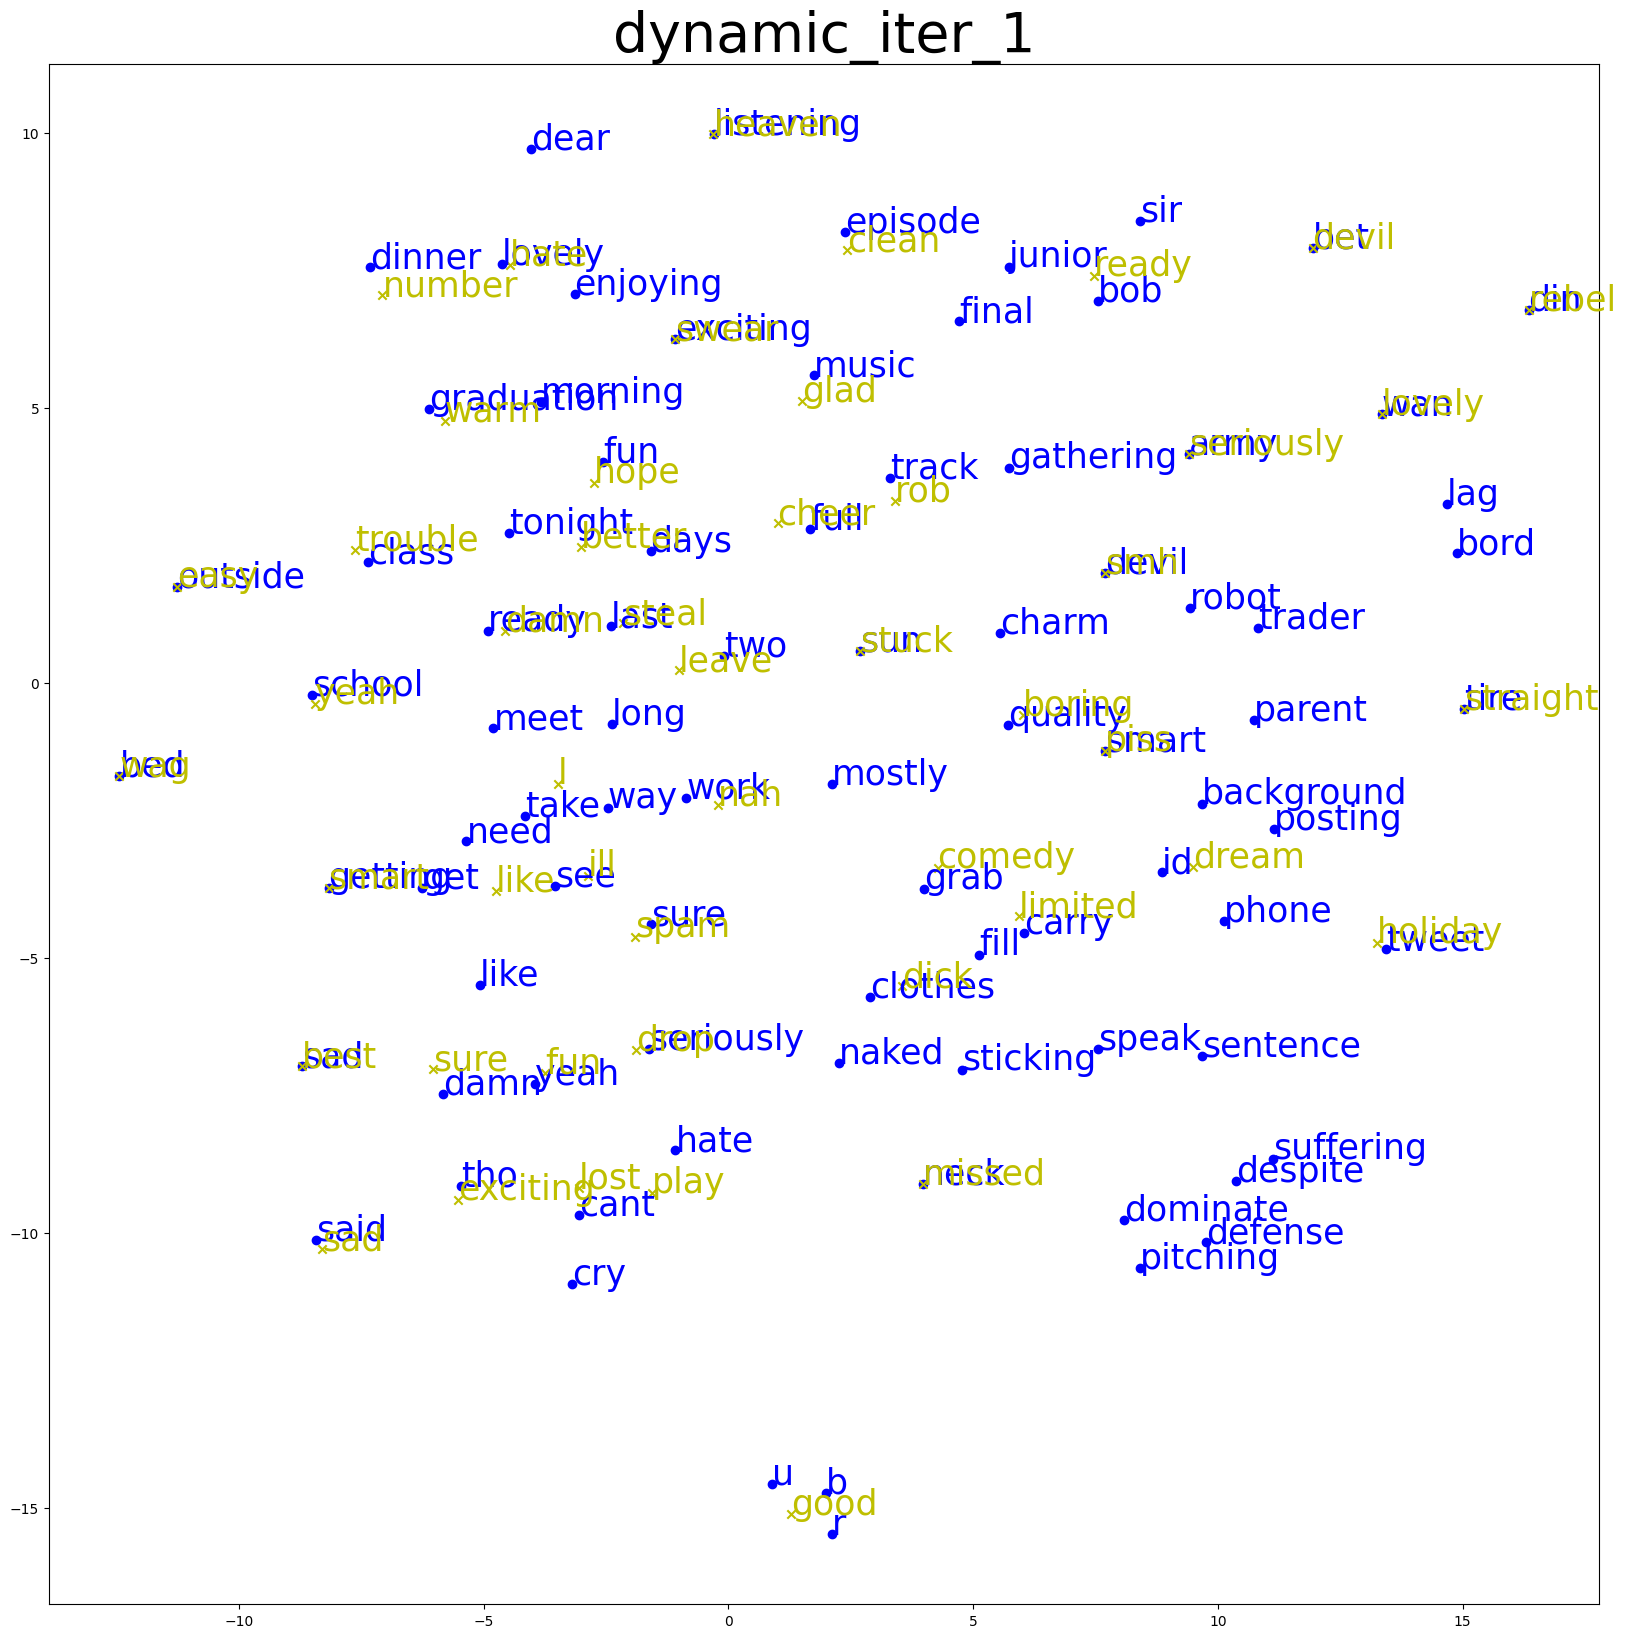

INFO: Iteration 2


Reassigning Points: 100%|██████████| 414/414 [00:14<00:00, 28.38it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'good' 'better' 'l' 'leave' 'lost' 'ill' 'hope' 'fun' 'yeah'
 'glad' 'dream' 'number' 'holiday' 'stuck' 'spam' 'sure' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'easy' 'heaven' 'trouble' 'boring'
 'limited' 'steal' 'missed' 'dick' 'clean' 'comedy' 'drop' 'seriously'
 'rebel' 'wag' 'warm' 'cheer' 'best' 'sad' 'swear' 'exciting' 'smh'
 'devil' 'piss' 'smart' 'straight' 'fume']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


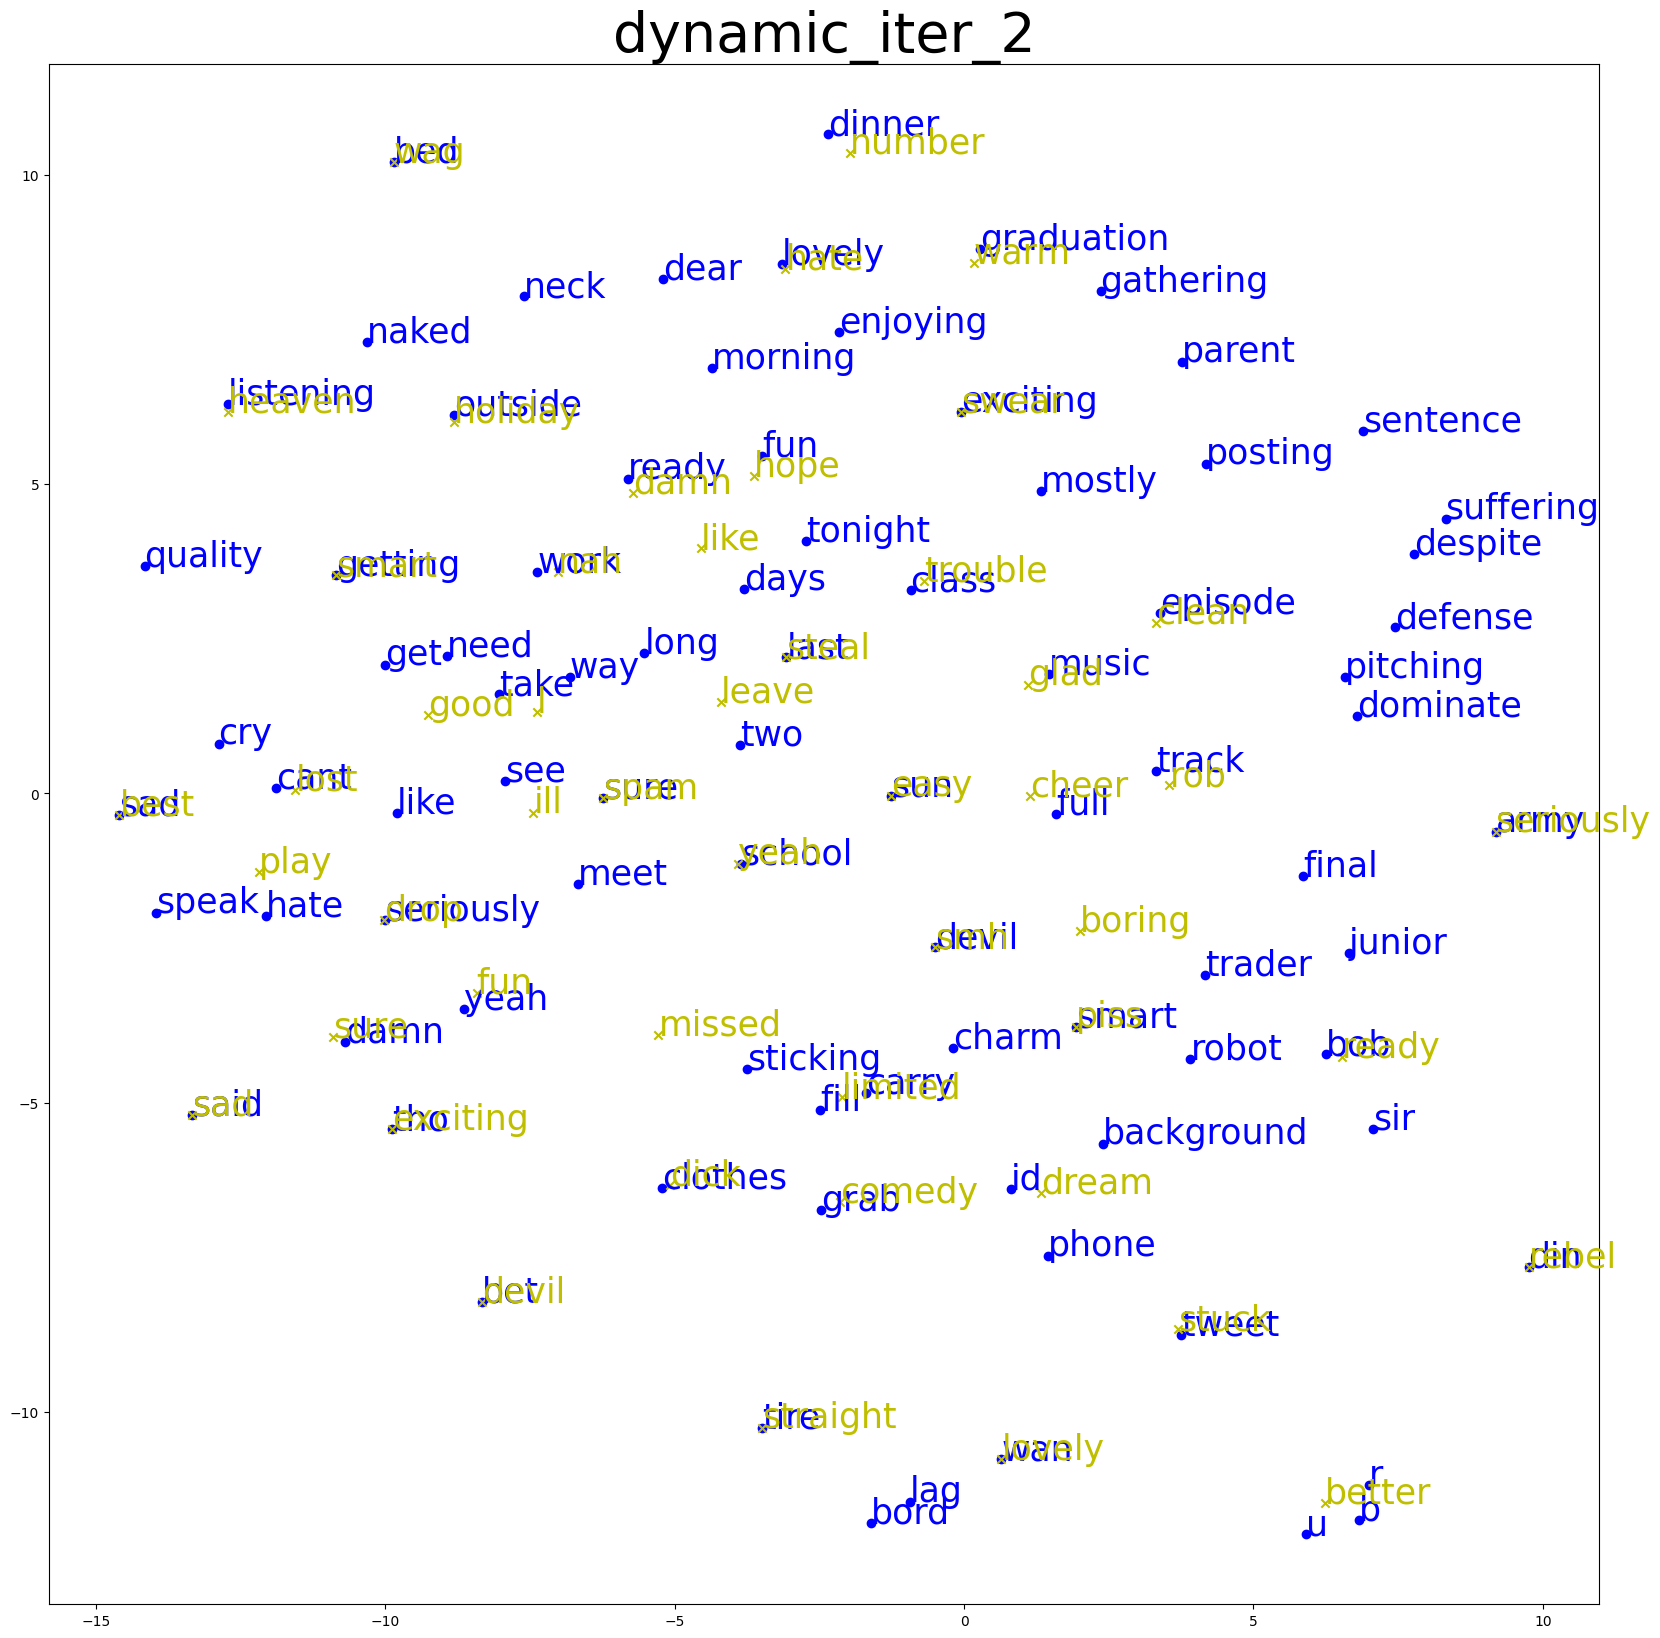

INFO: Iteration 3


Reassigning Points: 100%|██████████| 414/414 [00:14<00:00, 28.12it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'good' 'l' 'better' 'leave' 'lost' 'ill' 'hope' 'fun' 'yeah'
 'glad' 'dream' 'number' 'holiday' 'stuck' 'spam' 'sure' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'easy' 'heaven' 'trouble' 'boring'
 'limited' 'steal' 'missed' 'dick' 'clean' 'comedy' 'drop' 'seriously'
 'rebel' 'wag' 'warm' 'cheer' 'best' 'sad' 'swear' 'exciting' 'smh'
 'devil' 'piss' 'smart' 'straight' 'fume']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


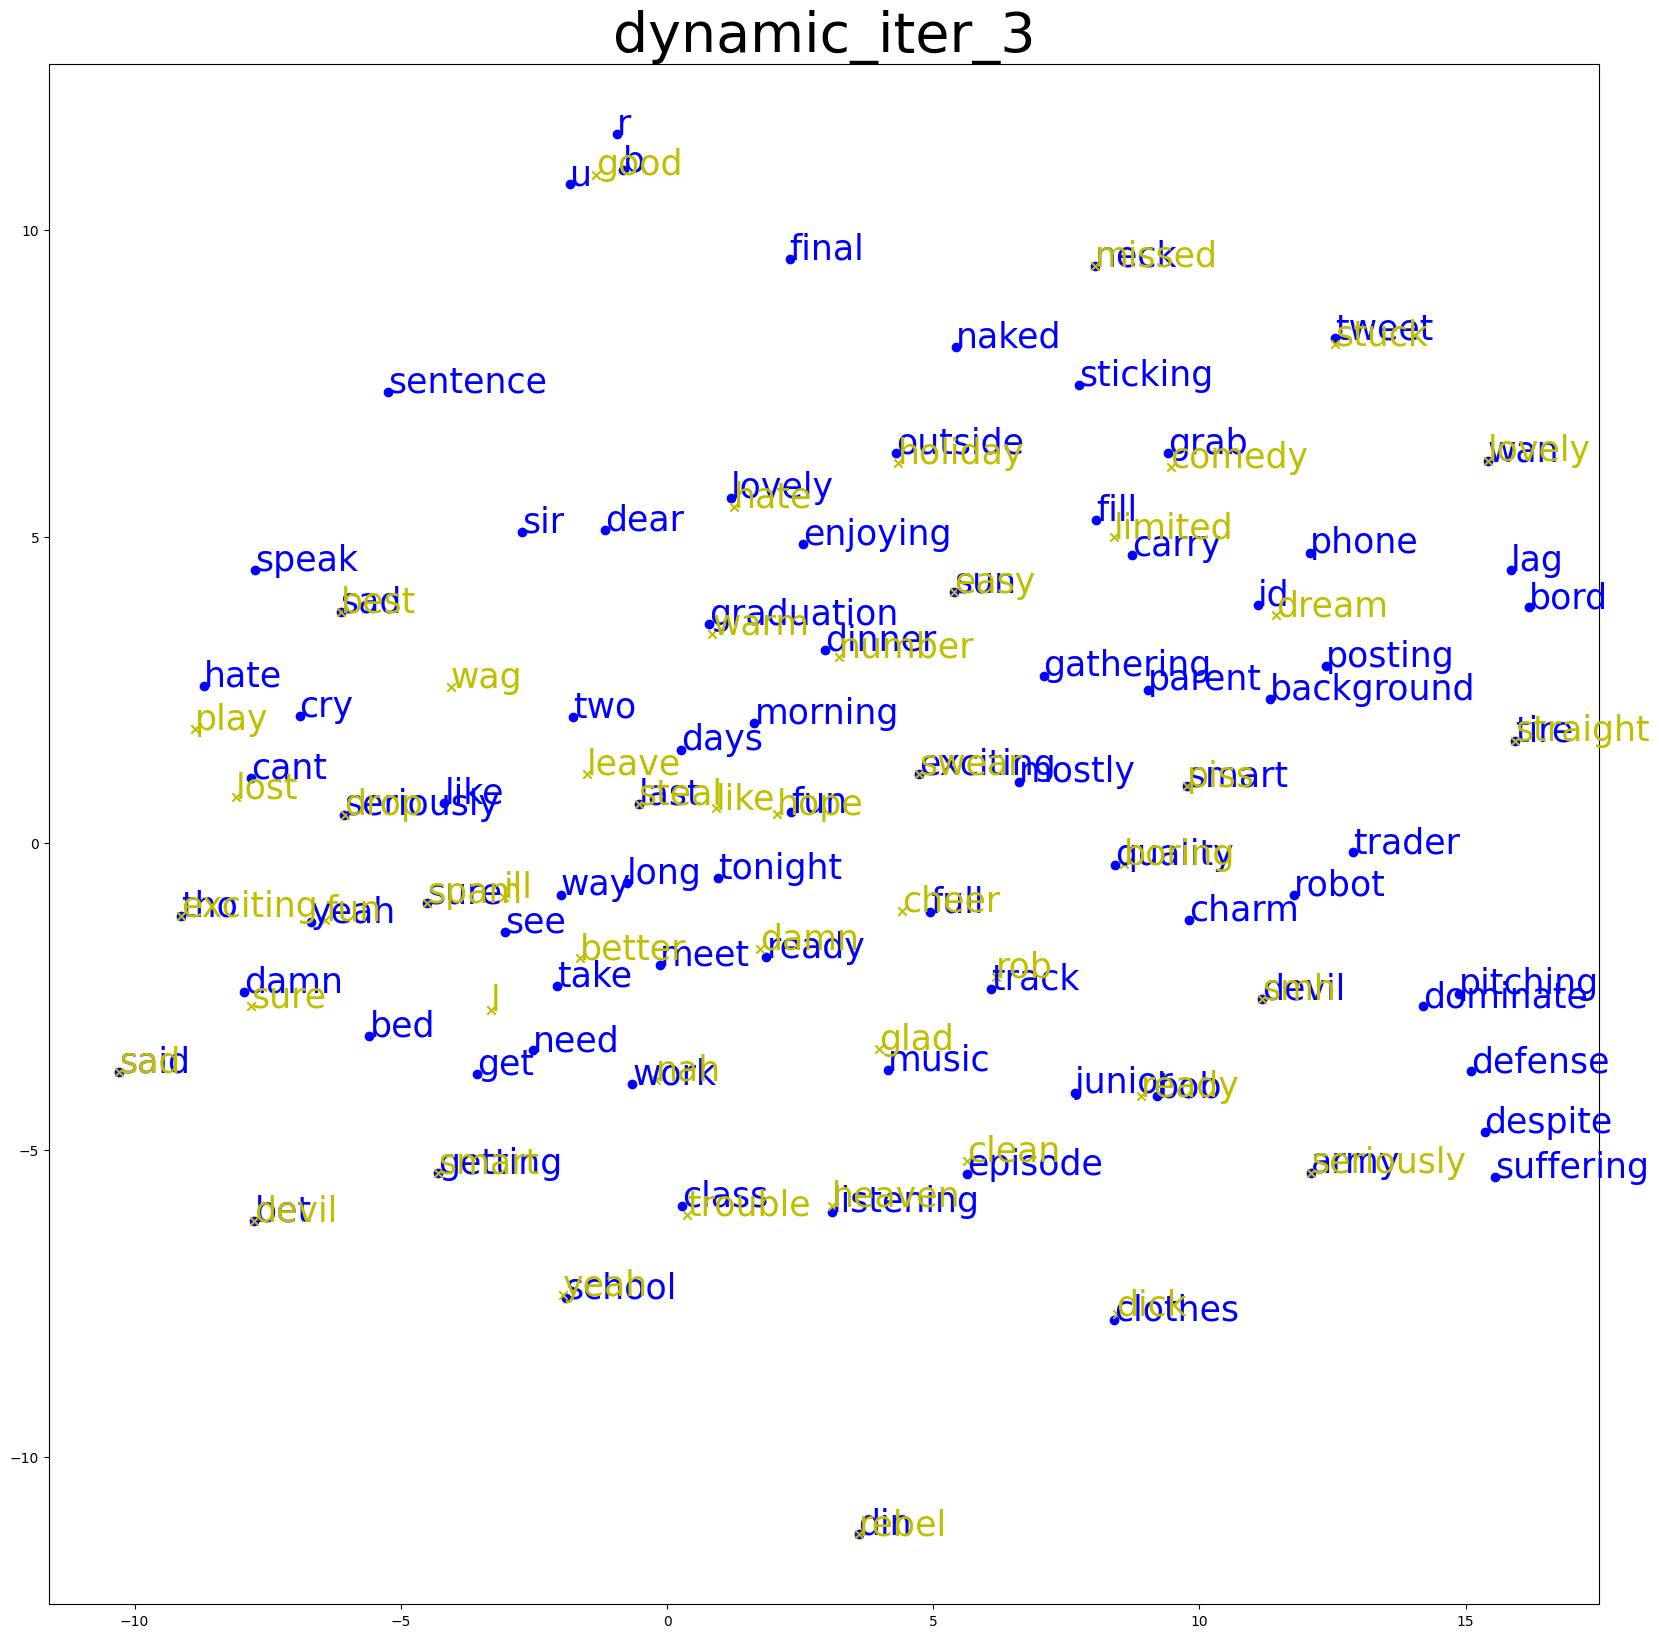

INFO: Iteration 4


Reassigning Points: 100%|██████████| 414/414 [00:14<00:00, 28.25it/s]
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'good' 'l' 'better' 'leave' 'lost' 'ill' 'hope' 'fun' 'yeah'
 'glad' 'dream' 'number' 'holiday' 'stuck' 'spam' 'sure' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'easy' 'heaven' 'trouble' 'boring'
 'limited' 'steal' 'missed' 'dick' 'clean' 'comedy' 'drop' 'seriously'
 'rebel' 'wag' 'warm' 'cheer' 'best' 'sad' 'swear' 'exciting' 'smh'
 'devil' 'piss' 'smart' 'straight' 'fume']
shape of concatenated 2D TSNE vector is (135, 2)
SUCCESS: Plot saved successfully


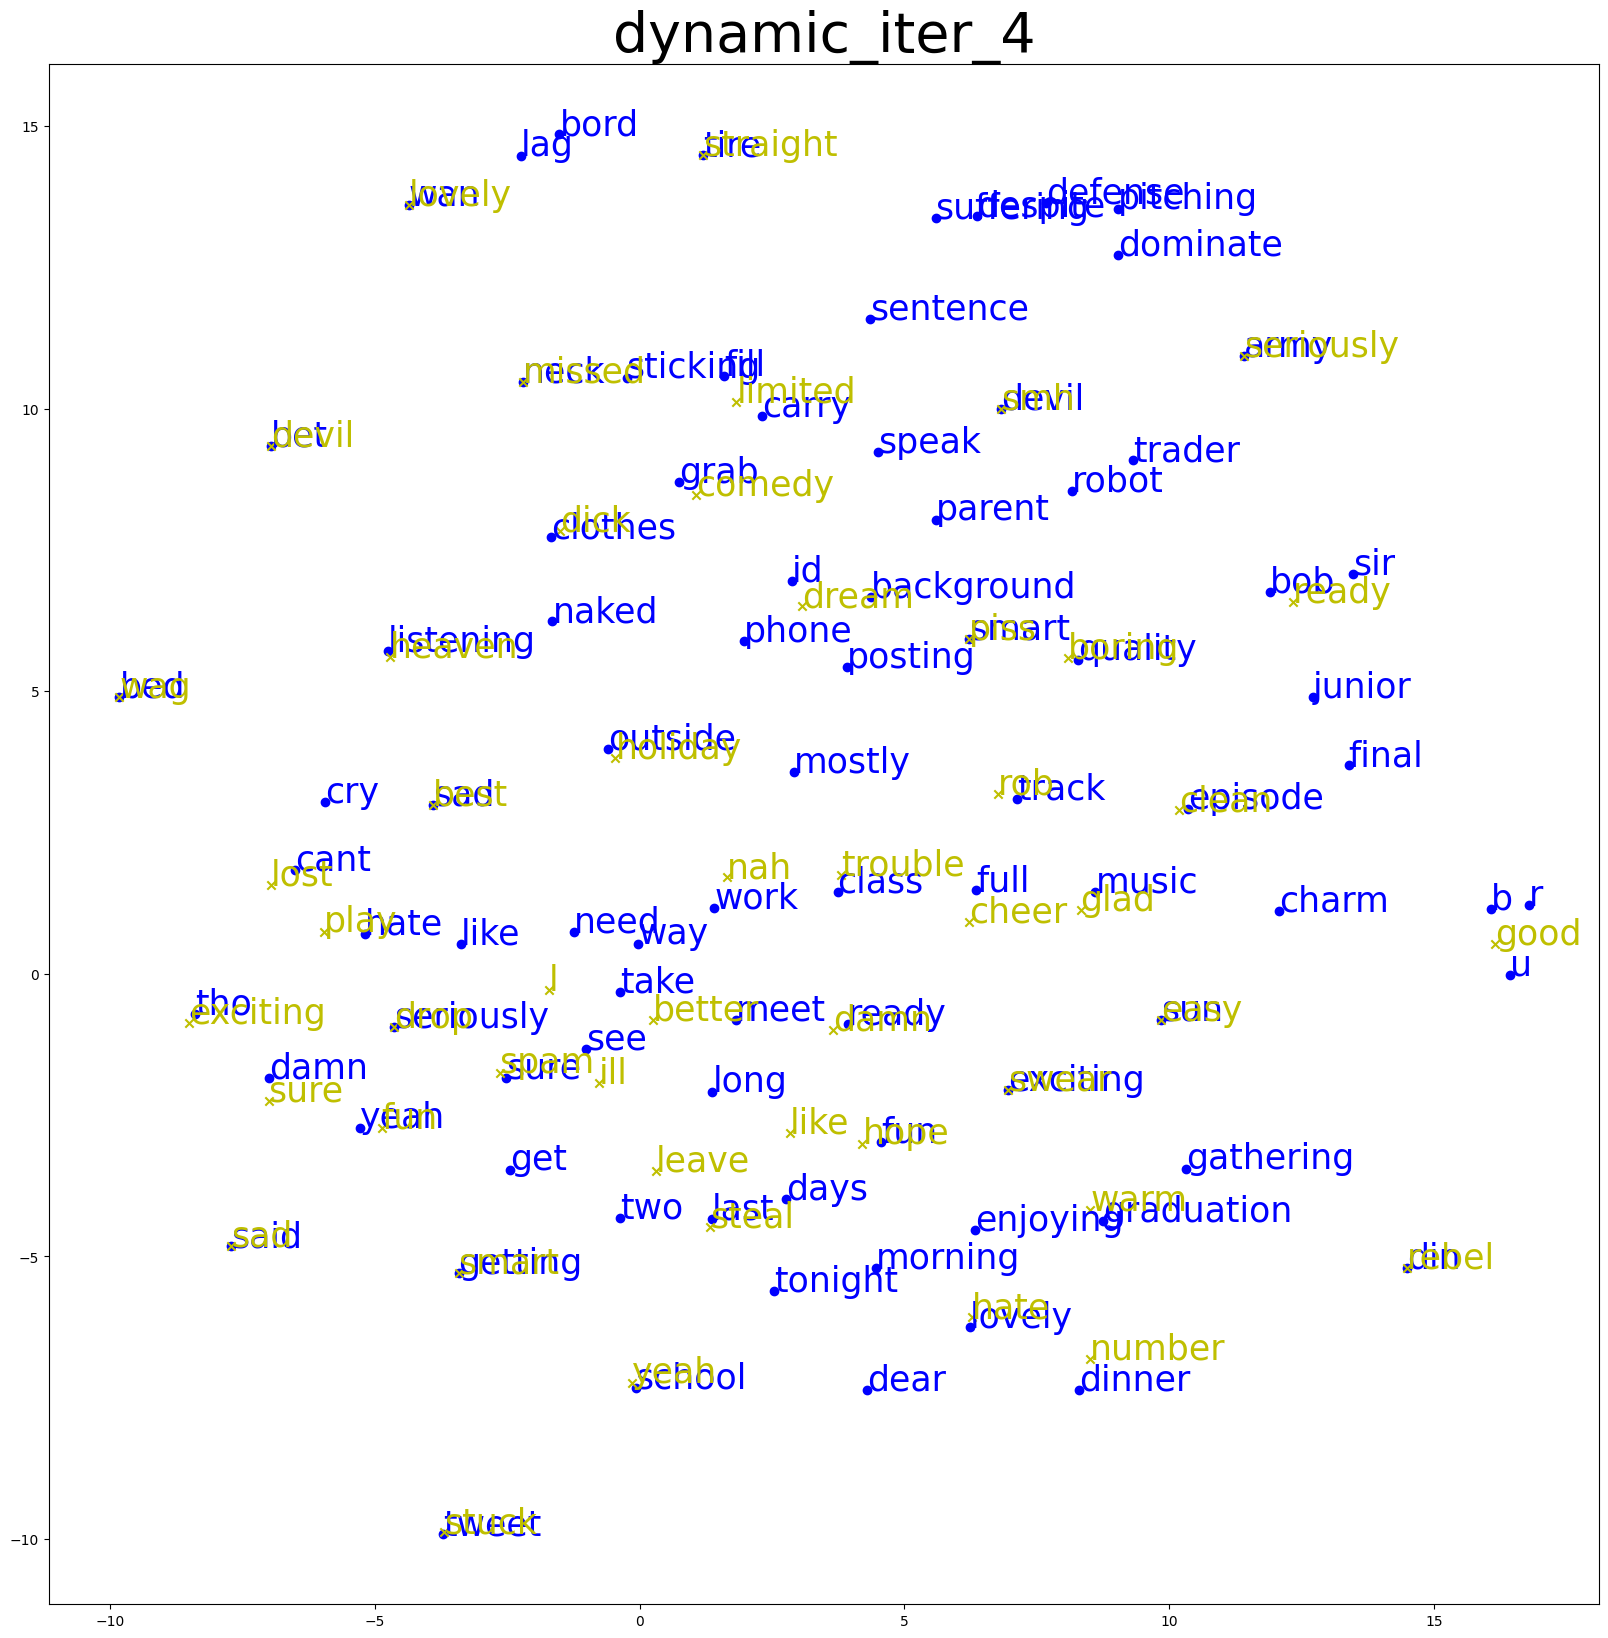

True

In [104]:
vector_space_dynamic = VectorSpace(word2vec_model, analyzer)
vector_space_dynamic.fit(X_train, dynamic=True, max_iterations = 20, save_plot=True)

In [59]:
# pickle trained vector spaces

import pickle

container = {
    "static_VectorSpace": vector_space_static,
    "dynamic_VectorSpace": vector_space_dynamic,
    "lexical_dictionary": analyzer,
    "word2vec_model": word2vec_model,
}

with open('container.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(container, f, pickle.HIGHEST_PROTOCOL)

In [60]:
import pickle


with open('container.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    container = pickle.load(f)


vector_space_static = container["static_VectorSpace"]
vector_space_dynamic = container["dynamic_VectorSpace"]
analyzer = container["lexical_dictionary"]
word2vec_model = container["word2vec_model"]

### Transforming Training and Test Sets

In [61]:
X_train_static_transformed = vector_space_static.transform(X_train, static=True)
X_test_static_transformed = vector_space_static.transform(X_test, static=True)

In [62]:
X_train_dynamic_transformed = vector_space_dynamic.transform(X_train, dynamic=True)
X_test_dynamic_transformed = vector_space_dynamic.transform(X_test, dynamic=True)

### Supervised Training 

In this section, we will train two supervised models: PassiveAggressive Classifier and a baseline Logistic Regression

In [63]:
def get_F1(precision, recall):
    if precision == recall == 0:
        return 0
    return 2* (precision*recall)/(precision+recall)

def model_pipeline(model, X_train_transformed, y_train, X_test_transformed, y_test):
    model.fit(X_train_transformed, y_train)
    pred = model.predict(X_test_transformed)

    loss = log_loss(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    F1 = get_F1(precision,recall)
    results = {
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "F1 Score": F1
    }
    # print(results)
    return results


In [64]:
pac_static_model = PassiveAggressiveClassifier(C = 0.5, random_state = RANDOM_STATE)

pac_static_results = model_pipeline(pac_static_model, X_train_static_transformed, y_train, X_test_static_transformed, y_test)
pa_static_results = pd.DataFrame(pac_static_results, index=["PA_static"])

In [65]:
pac_dynamic_model = PassiveAggressiveClassifier(C = 0.5, random_state = RANDOM_STATE)

pac_dynamic_results = model_pipeline(pac_dynamic_model, X_train_dynamic_transformed, y_train, X_test_dynamic_transformed, y_test)
pa_dynamic_results = pd.DataFrame(pac_dynamic_results, index=["PA_dynamic"])

In [66]:
logit_static_model = LogisticRegression(random_state=RANDOM_STATE) 

logit_static_results = model_pipeline(logit_static_model, X_train_static_transformed, y_train, X_test_static_transformed, y_test)
logit_static_results = pd.DataFrame(logit_static_results, index=["Logit_static"])

In [67]:
logit_dynamic_model = LogisticRegression(random_state=RANDOM_STATE) 

logit_dynamic_results = model_pipeline(logit_dynamic_model, X_train_dynamic_transformed, y_train, X_test_dynamic_transformed, y_test)
logit_dynamic_results = pd.DataFrame(logit_dynamic_results, index=["Logit_dynamic"])

In [68]:
from sklearn import svm

svm_static_model = svm.SVC()
svm_static_results = model_pipeline(svm_static_model, X_train_static_transformed, y_train, X_test_static_transformed, y_test)
svm_static_results = pd.DataFrame(svm_static_results, index=["svm_static"])

In [69]:
svm_dynamic_model = svm.SVC()
svm_dynamic_results = model_pipeline(svm_dynamic_model, X_train_dynamic_transformed, y_train, X_test_dynamic_transformed, y_test)
svm_dynamic_results = pd.DataFrame(svm_dynamic_results, index=["svm_dynamic"])

In [70]:
import lightgbm as lgb

lgbm_static_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=RANDOM_STATE)
lgbm_static_results = model_pipeline(lgbm_static_model, X_train_static_transformed, y_train, X_test_static_transformed, y_test)
lgbm_static_results = pd.DataFrame(lgbm_static_results, index=["lgbm_static"])

In [71]:
lgbm_dynamic_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=RANDOM_STATE)
lgbm_dynamic_results = model_pipeline(lgbm_dynamic_model, X_train_dynamic_transformed, y_train, X_test_dynamic_transformed, y_test)
lgbm_dynamic_results = pd.DataFrame(lgbm_dynamic_results, index=["lgbm_dynamic"])

In [72]:
combined_results = pd.concat([pa_static_results, pa_dynamic_results, logit_static_results,  logit_dynamic_results,svm_static_results,svm_dynamic_results, lgbm_static_results, lgbm_dynamic_results])
combined_results

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
PA_static,23.026304,0.333333,0.227273,0.625,0.426136,0.333333
PA_dynamic,25.328942,0.266667,0.208333,0.625,0.380682,0.312500
Logit_static,23.026304,0.333333,0.227273,0.625,0.426136,0.333333
Logit_dynamic,25.328916,0.266667,0.181818,0.500,0.340909,0.266667
svm_static,21.875011,0.366667,0.260870,0.750,0.488636,0.387097
svm_dynamic,21.874985,0.366667,0.238095,0.625,0.448864,0.344828
lgbm_static,20.723692,0.400000,0.272727,0.750,0.511364,0.400000
lgbm_dynamic,23.026331,0.333333,0.250000,0.750,0.465909,0.375000


In [73]:
import random
class VectorSpaceVisualiser:
    def __init__(self, Vector_Space):
        self.vector_space = Vector_Space

    def plot(self, n_point, n_centroid):
        tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
        plt.figure(figsize=(20,20))

        # retrieving words
        random.seed(RANDOM_STATE) # can set to other number and see how
        sampled_points = random.sample(self.vector_space.points, n_point)
        words = []
        vectors = []
        for point in sampled_points:
            if point.word not in words: # make sure there's no repeated words
                words.append(point.word)
                vectors.append(point.vector)
        words = np.array(words)
        vectors = np.array(vectors)
        n_unique_words = words.shape[0]
        print(f"number of unique words plotted is {n_unique_words}")


        # retrieving their closest centroids
        centroids = [point.closest_centroid for point in sampled_points]
        centroids.sort(reverse = True, key = lambda x: len(x.cluster_points))

        # make sure centroids with the most number of cluster points are plotted first
        lexicons = []
        lexicon_vectors = []
        for centroid in centroids:
            if centroid.word not in lexicons: # make sure there's no repeated words
                lexicons.append(centroid.word)
                lexicon_vectors.append(centroid.vector)
        lexicons = np.array(lexicons)[:n_centroid]
        lexicon_vectors = np.array(lexicon_vectors)[:n_centroid]
        print(f"the list of {lexicons.shape[0]} lexicons centroids plotted is as follows, {lexicons}")

        conc_vectors = np.concatenate((vectors, lexicon_vectors))
        conc_tsne = tsne.fit_transform(conc_vectors) # transforming to 2D
        print(f"shape of concatenated 2D TSNE vector is {conc_tsne.shape}")

        X_tsne = conc_tsne[:n_unique_words, :]
        centroid_tsne = conc_tsne[n_unique_words+1:, :]

        # plotting points
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = 'b')
        for label, x, y in zip(words, X_tsne[:, 0], X_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset pixels", c = 'b', fontsize = 25)

        # plotting centroids
        plt.scatter(centroid_tsne[:, 0], centroid_tsne[:, 1], color = 'y', marker = 'x')
        for label, x, y in zip(lexicons, centroid_tsne[:, 0], centroid_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset pixels", c = 'y', fontsize = 25)

        plt.show()

number of unique words plotted is 85
the list of 50 lexicons centroids plotted is as follows, ['like' 'good' 'l' 'better' 'leave' 'lost' 'ill' 'hope' 'fun' 'yeah'
 'glad' 'dream' 'number' 'holiday' 'stuck' 'spam' 'sure' 'damn' 'ready'
 'rob' 'play' 'hate' 'lovely' 'nah' 'easy' 'heaven' 'trouble' 'boring'
 'limited' 'steal' 'missed' 'dick' 'clean' 'comedy' 'drop' 'seriously'
 'rebel' 'wag' 'warm' 'cheer' 'best' 'sad' 'swear' 'exciting' 'smh'
 'devil' 'piss' 'smart' 'straight' 'fume']


c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\edmun\Dropbox\NUS\Work\Y4S1\02807 - Computational Tools for Data Science\Project\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


shape of concatenated 2D TSNE vector is (135, 2)


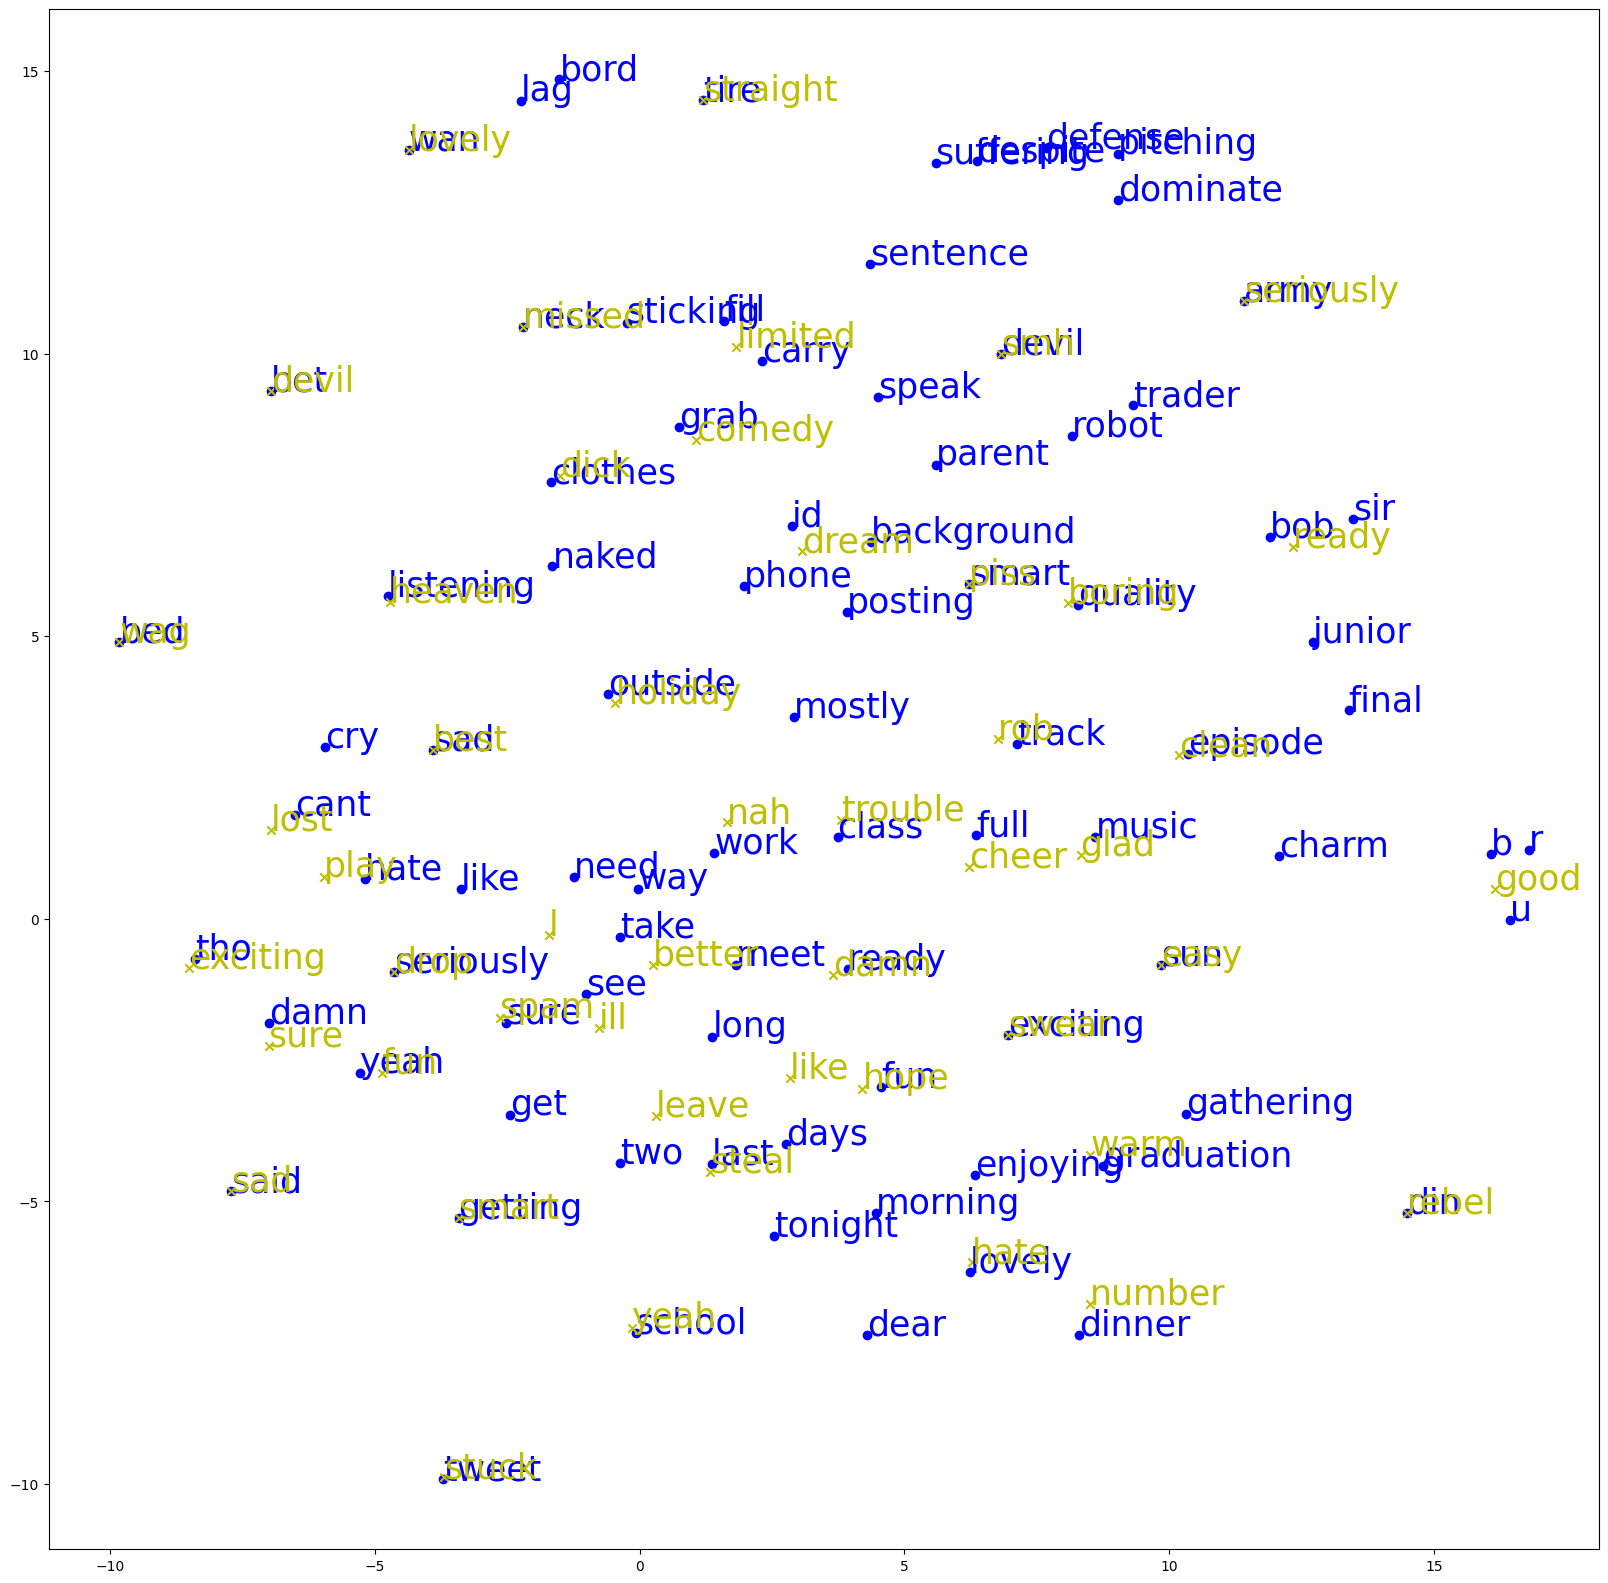

In [74]:
visualiser_static = VectorSpaceVisualiser(vector_space_dynamic)
visualiser_static.plot(n_point=100, n_centroid= 50)